# Variant level notebook import example

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

def _resolve_project_root() -> Path:
    """locate project root containing config.py."""
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')

PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# now import from config
from config import (
    VARIANT_PATHS,
    GENE_PATHS,
    SOURCE_PALETTE,
    load_variants_processed,
    load_variant_pairs_matched,
)

In [2]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_VAR,
    'background_null': BG_NULL_VAR,
    'clingen': CLINGEN_VAR,
    'clingen_null': CLINGEN_NULL_VAR,
}

df = pl.read_parquet(BG_VAR)
print(df.columns)

['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'is_anchor', 'seq_len', 'scorer_friendly', 'gene_norm', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'method_friendly', 'variant_id_canonical', 'CHROM_af', 'POS_af', 'REF_af', 'ALT_af', 'AF', 'vg_predicted']


In [3]:
# load matched background real and null variants with downsampling
real_bg, null_bg = load_variant_pairs_matched(
    real_dataset='background',
    null_dataset='background_null',
    downsample=True,
    seed=42,
    verbose=True,
)

# load matched clingen real and null variants with downsampling
real_cg, null_cg = load_variant_pairs_matched(
    real_dataset='clingen',
    null_dataset='clingen_null',
    downsample=True,
    seed=42,
    verbose=True,
)

Output()

Dataset Matching Summary                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric         ┃ Background ┃ Background_null ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Total Variants │ 1,461,094  │ 1,451,874       │
│ Unique Genes   │ 349        │ 349             │
│ Gene Overlap   │ 349        │ 349             │
└────────────────┴────────────┴─────────────────┘

Columns available: variant_id, scored_interval, gene_id, gene_name, gene_type... (37 total)

Output()

Dataset Matching Summary                     
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric         ┃ Clingen   ┃ Clingen_null ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Total Variants │ 1,446,682 │ 1,439,828    │
│ Unique Genes   │ 316       │ 316          │
│ Gene Overlap   │ 316       │ 316          │
└────────────────┴───────────┴──────────────┘

Columns available: variant_id, scored_interval, gene_id, gene_name, gene_type... (37 total)

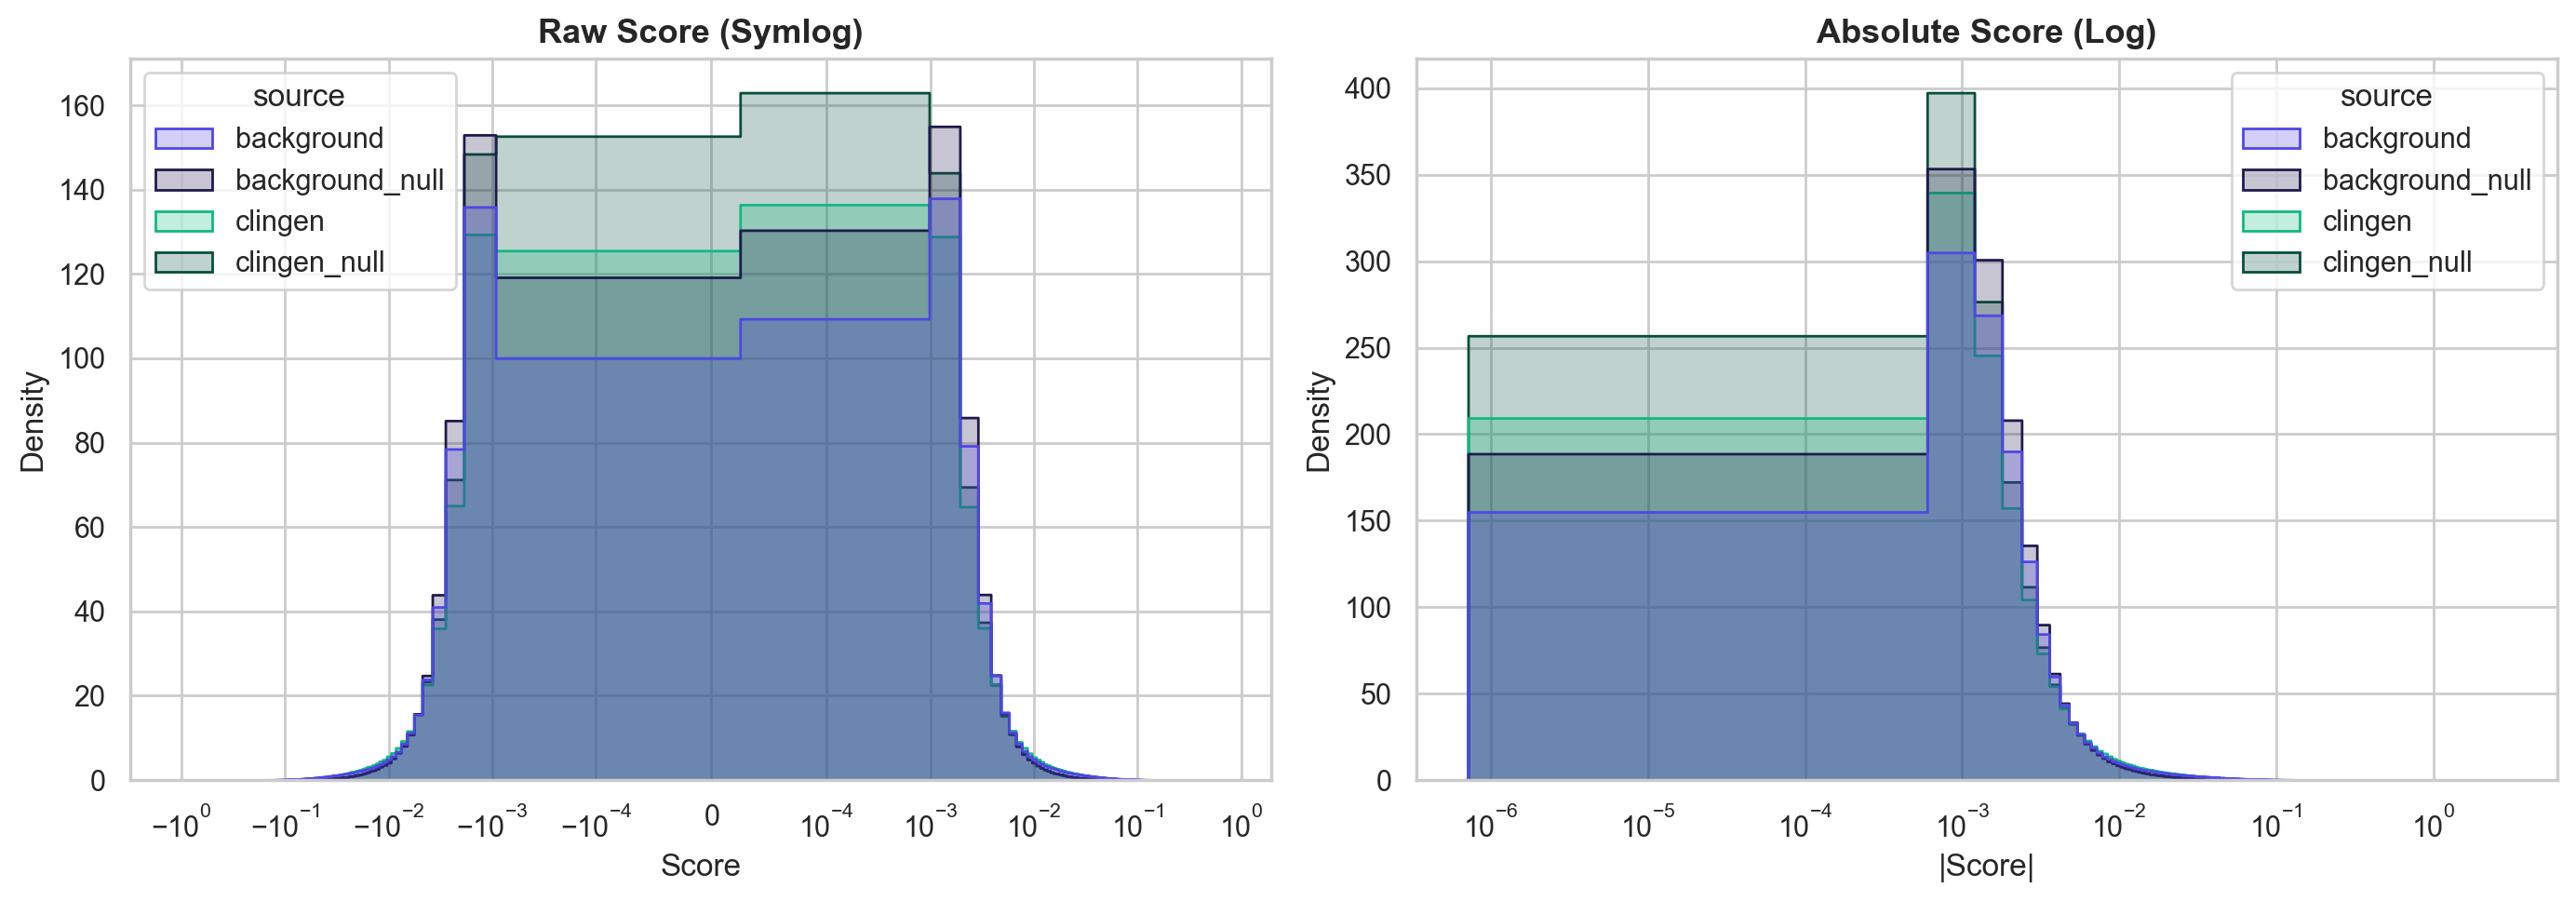

In [5]:
plt.rcParams['figure.dpi'] = 200

def prepare_for_plot(df: pl.DataFrame, label: str) -> pl.DataFrame:
    """Ensure dataframe has raw_score, abs_score, and source label."""
    # Note: load_variants_processed already renames 'score' to 'raw_score'
    return df.with_columns(
        abs_score=pl.col('raw_score').abs(),
        source=pl.lit(label)
    ).select(['raw_score', 'abs_score', 'source'])

def plot_raw_and_abs_scores_matched(
    datasets: list[tuple[pl.DataFrame, str]]
) -> None:
    """
    Plot distributions using already loaded/matched dataframes.
    Args:
        datasets: List of tuples like [(real_bg, 'background'), ...]
    """
    # 1. Process and Combine all datasets
    plot_data = pl.concat([
        prepare_for_plot(df, label) for df, label in datasets
    ]).to_pandas()

    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Define the order to match your SOURCE_PALETTE keys
    hue_order = [label for _, label in datasets]

    # --- Plot 1: Raw Scores ---
    sns.histplot(
        data=plot_data,
        x='raw_score',
        hue='source',
        hue_order=hue_order,
        stat='density',
        element='step',
        common_norm=False,
        palette=SOURCE_PALETTE,
        ax=axes[0],
        alpha=0.25,
    )
    axes[0].set_xscale('symlog', linthresh=1e-4)
    axes[0].set_title('Raw Score (Symlog)', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Density')

    # --- Plot 2: Absolute Scores ---
    sns.histplot(
        data=plot_data,
        x='abs_score',
        hue='source',
        hue_order=hue_order,
        stat='density',
        element='step',
        common_norm=False,
        palette=SOURCE_PALETTE,
        ax=axes[1],
        alpha=0.25,
    )
    axes[1].set_xscale('log')
    axes[1].set_title('Absolute Score (Log)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('|Score|')
    axes[1].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

# Execute using your downsampled dataframes
plot_raw_and_abs_scores_matched([
    (real_bg, 'background'),
    (null_bg, 'background_null'),
    (real_cg, 'clingen'),
    (null_cg, 'clingen_null')
])

In [7]:
BASES = {'A', 'C', 'G', 'T'}

def get_methylation_proportions_from_df(df: pl.DataFrame, label: str) -> pl.DataFrame:
    """Summarize methylation using an existing dataframe."""
    schema_cols = set(df.columns)
    
    if 'methylation_bin' in schema_cols:
        col = 'methylation_bin'
        df_binned = df.with_columns(pl.col('methylation_bin').cast(pl.Utf8))
    elif 'quantile_score' in schema_cols:
        col = 'methylation_bin'
        score = pl.col('quantile_score')
        df_binned = df.with_columns(
            pl.when(score < 0.2).then(pl.lit('0-0.2'))
            .when(score < 0.4).then(pl.lit('0.2-0.4'))
            .when(score < 0.6).then(pl.lit('0.4-0.6'))
            .when(score < 0.8).then(pl.lit('0.6-0.8'))
            .otherwise(pl.lit('0.8-1.0'))
            .alias('methylation_bin')
        )
    else:
        # If no methylation data, return empty to avoid breaking concat
        return pl.DataFrame({'methylation_bin': [], 'len': [], 'source': [], 'proportion': []})

    grouped = (
        df_binned.group_by('methylation_bin')
        .agg(pl.len().alias('len'))
        .sort('methylation_bin')
        .with_columns(pl.lit(label).alias('source'))
    )

    total = grouped['len'].sum()
    return grouped.with_columns((pl.col('len') / total).alias('proportion'))


def get_mutation_spectrum_from_df(df: pl.DataFrame, label: str) -> pl.DataFrame:
    """Compute mutation spectrum using an existing dataframe."""
    # Filter for standard SNPs
    filtered = df.filter(
        pl.col('REF').is_in(BASES) & 
        pl.col('ALT').is_in(BASES) &
        (pl.col('REF') != pl.col('ALT'))
    )

    if filtered.is_empty():
        return pl.DataFrame({'mutation': [], 'len': [], 'proportion': [], 'source': []})

    grouped = (
        filtered.with_columns(
            pl.concat_str([pl.col('REF'), pl.lit('>'), pl.col('ALT')]).alias('mutation')
        )
        .group_by('mutation')
        .agg(pl.len().alias('len'))
        .sort('mutation')
        .with_columns(pl.lit(label).alias('source'))
    )

    total = grouped['len'].sum()
    return grouped.with_columns((pl.col('len') / total).alias('proportion'))

In [10]:
def annotate_bar_counts(ax, df, bin_order: list[str], hue_order: list[str]) -> None:
    """annotate barplot bars with variant counts using coordinate-based matching.
    
    args:
        ax (plt.Axes): target axes.
        df (pd.DataFrame): plotted data with len and source columns.
        bin_order (list[str]): x-order of methylation bins.
        hue_order (list[str]): hue order for sources.
    """
    # 1. Create a lookup dictionary: (bin_name, source_name) -> count
    counts_lookup = {
        (row['methylation_bin'], row['source']): int(row['len'])
        for _, row in df.iterrows()
    }

    # 2. Define styling thresholds
    max_height = ax.get_ylim()[1]
    threshold = max_height * 0.10  # If bar is taller than 10%, put text inside
    offset = max_height * 0.01     # Vertical offset for text on top

    # 3. Group patches by their rounded X-coordinate (Bin Index)
    # Seaborn places ticks at 0, 1, 2, 3... so round(x) gives the Bin Index.
    bin_patches = {}
    for patch in ax.patches:
        # Skip empty/invisible bars
        if patch.get_height() <= 0 or not pd.notnull(patch.get_height()):
            continue
            
        center_x = patch.get_x() + patch.get_width() / 2
        bin_idx = int(round(center_x))
        
        if bin_idx not in bin_patches:
            bin_patches[bin_idx] = []
        bin_patches[bin_idx].append(patch)

    # 4. Process each Bin Group
    for bin_idx, patches in bin_patches.items():
        if bin_idx >= len(bin_order):
            continue
            
        bin_name = bin_order[bin_idx]
        
        # Sort patches in this bin from Left to Right -> matches Hue Order
        patches.sort(key=lambda p: p.get_x())
        
        for hue_idx, patch in enumerate(patches):
            if hue_idx >= len(hue_order):
                continue
                
            source_name = hue_order[hue_idx]
            count = counts_lookup.get((bin_name, source_name))
            
            if count is None:
                continue

            height = patch.get_height()
            
            # Dynamic Styling Logic
            if height > threshold:
                # Tall bar: Place inside, white text, centered
                y_pos = patch.get_y() + height / 2
                color = 'white'
                va = 'center'
            else:
                # Short bar: Place on top, black text
                y_pos = patch.get_y() + height + offset
                color = 'black'
                va = 'bottom'

            ax.text(
                patch.get_x() + patch.get_width() / 2,
                y_pos,
                f'{count:,}',
                ha='center',
                va=va,
                color=color,
                fontsize=9,
                rotation=90,
            )


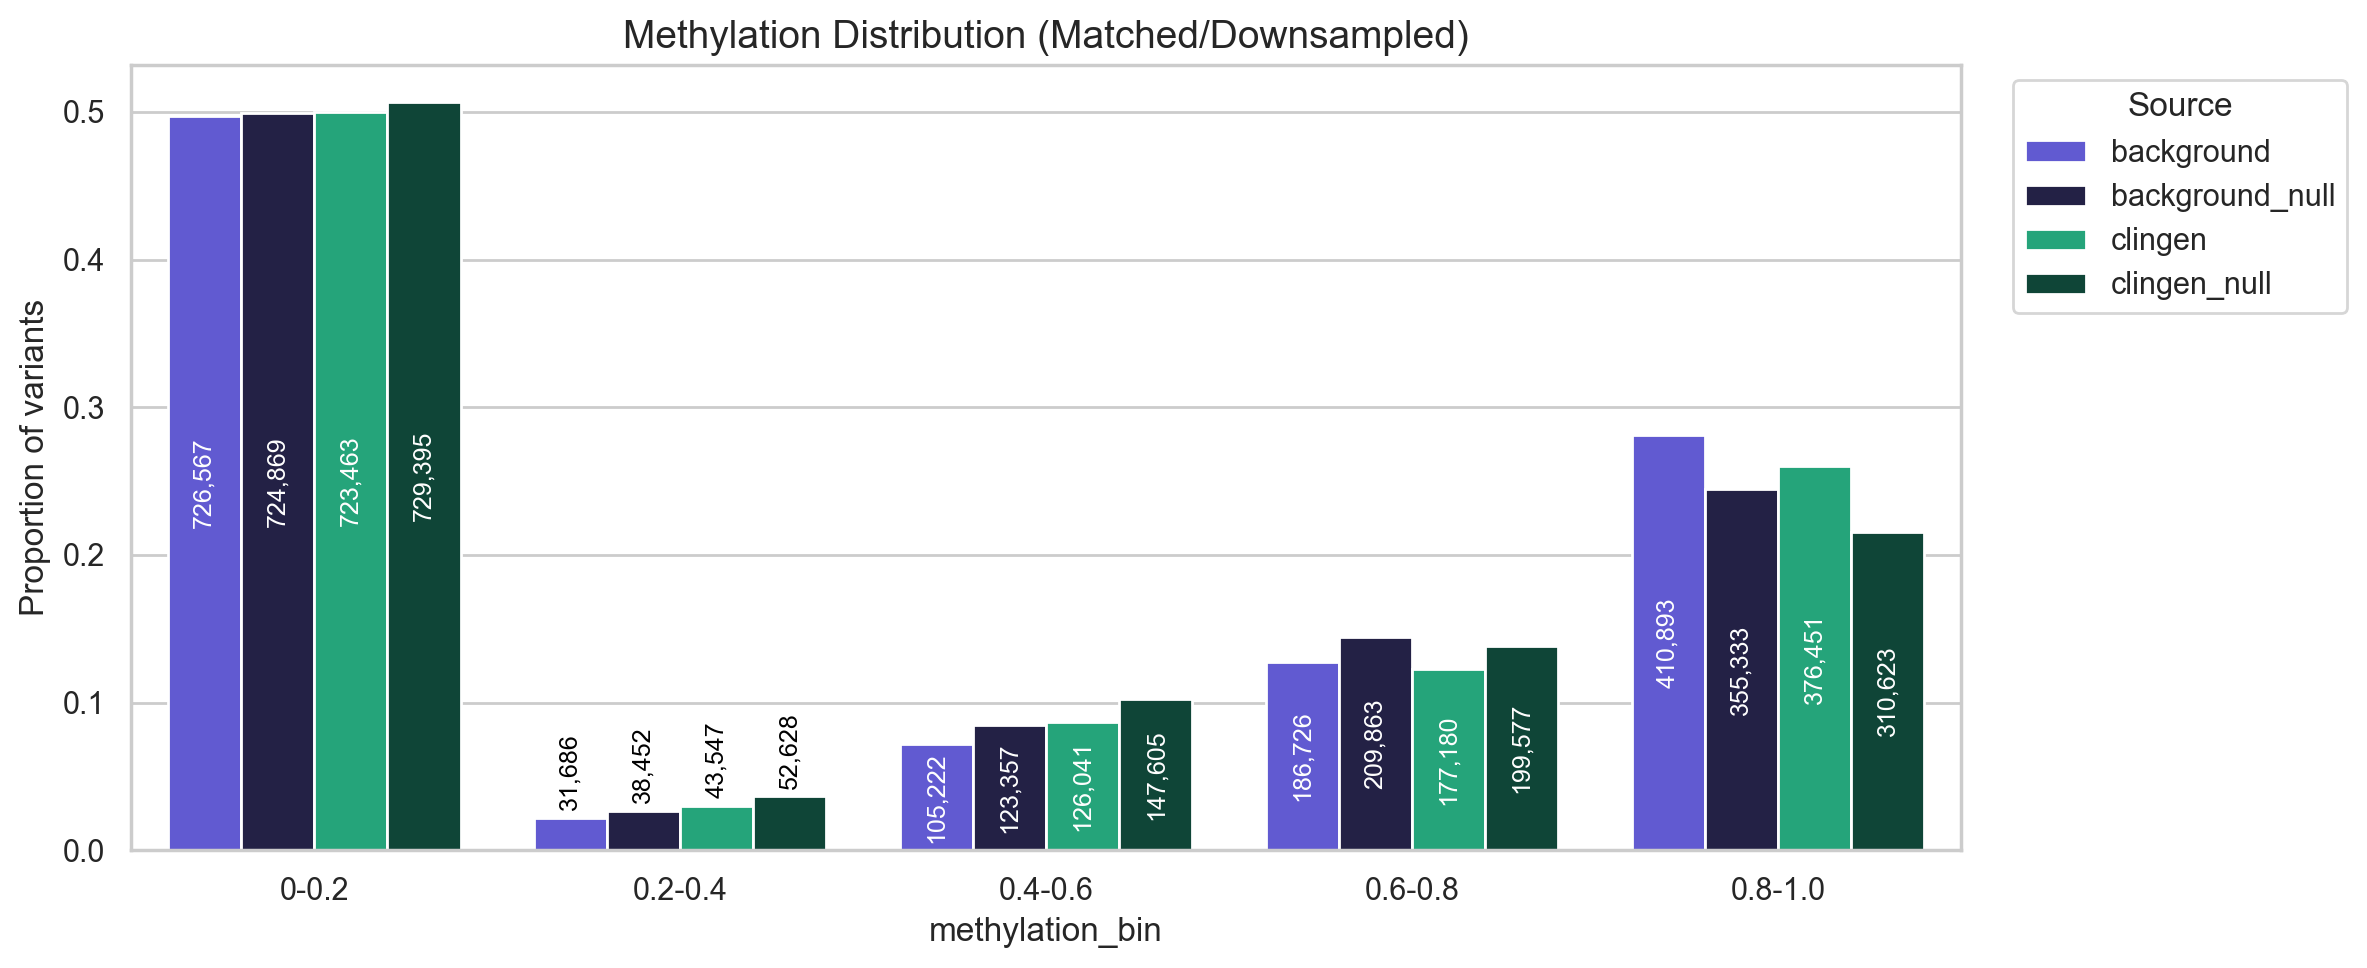

In [11]:
def plot_matched_methylation(bg_real, bg_null, cg_real, cg_null):
    """Plot methylation distribution for the matched dataset sets."""
    sns.set_theme(style='whitegrid')
    
    # Mapping of dataframes to labels
    df_map = {
        'background': bg_real,
        'background_null': bg_null,
        'clingen': cg_real,
        'clingen_null': cg_null
    }
    
    # Process all
    all_data = []
    for label, df in df_map.items():
        all_data.append(get_methylation_proportions_from_df(df, label))
    
    data = pl.concat(all_data)
    
    bin_order = sorted(data['methylation_bin'].unique())
    hue_order = ['background', 'background_null', 'clingen', 'clingen_null']
    df_plot = data.to_pandas()

    fig, ax = plt.subplots(figsize=(12, 5), dpi=200)
    sns.barplot(
        data=df_plot,
        x='methylation_bin',
        y='proportion',
        hue='source',
        palette=SOURCE_PALETTE,
        order=bin_order,
        hue_order=hue_order,
        ax=ax
    )

    # Use your existing annotation function
    annotate_bar_counts(ax, df_plot, bin_order, hue_order)

    ax.set_title('Methylation Distribution (Matched/Downsampled)', fontsize=14)
    ax.set_ylabel('Proportion of variants')
    ax.legend(title='Source', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Execution
plot_matched_methylation(real_bg, null_bg, real_cg, null_cg)